Greek Letters:
    	σ τ Ψ Θ δ ξ μ ω 
References:
    https://arxiv.org/pdf/hep-th/9810032.pdf
    https://juliaphysics.github.io/PhysicsTutorials.jl/tutorials/general/quantum_ising/quantum_ising.html

$$ H = \sum\limits_{i}[J (\frac{1+\gamma}{2})σ^{x}_{i}σ^{x}_{i+1} + J (\frac{1-\gamma}{2})σ^{y}_{i}σ^{y}_{i+1} + J_z σ^{z}_{i}σ^{z}_{i+1} + g σ^{z}_{i}] $$

I group the Hamiltonian into the 4 terms.

In [1]:
using LinearAlgebra
using Plots
using KrylovKit
# KrylovKit allows for exponentiate() 
#   https://jutho.github.io/KrylovKit.jl/stable/man/matfun/
#   exponentiate(A, t::Number, x) -> y=exp(t∗A)x

In [2]:
id = [[1 0] ; [0 1]].+0im;
σx = [[0 1] ; [1 0]].+0im;
σy = [[0 -im] ; [im 0]];
σz = [[1 0] ; [0 -1]].+0im;

⊗(x,y) = kron(x,y);

In [3]:
"""
Binary `BitArray` representation of the given integer `num`, padded to length `N`.
"""
bit_rep(num::Integer, N::Integer) = BitArray(parse(Bool, i) for i in string(num, base=2, pad=N))

"""
    generate_basis(N::Integer) -> basis

Generates a basis (`Vector{BitArray}`) spanning the Hilbert space of `N` spins.
"""
function generate_basis(N::Integer)
    nstates = 2^N
    basis = Vector{BitArray{1}}(undef, nstates)
    for i in 0:nstates-1
        basis[i+1] = bit_rep(i, N)
    end
    return basis
end

function GetHamiltonian(N::Int64,g::Float64,𝛾::Float64,J::Float64,Jz::Float64)
    if N>12
        return nothing
    end
    
    # vector of operators: [σx, σx, id, ...]
    first_term_ops = fill(id, N)
    first_term_ops[1] = σx
    first_term_ops[2] = σx
    
    # vector of operators: [σy, σy, id, ...]
    second_term_ops = fill(id, N)
    second_term_ops[1] = σy
    second_term_ops[2] = σy
    
    # vector of operators: [σz, σz, id, ...]
    third_term_ops = fill(id, N)
    third_term_ops[1] = σz
    third_term_ops[2] = σz
    
    # vector of operators: [σz, id, ...]
    fourth_term_ops = fill(id, N)
    fourth_term_ops[1] = σz
    
    H = zeros(Int, 2^N, 2^N)
    # Term 1
    for i in 1:N-1
        # tensor multiply all operators
        H -= J*((1+𝛾)/2) * foldl(⊗, first_term_ops)
        # cyclic shift the operators
        first_term_ops = circshift(first_term_ops,1)
    end
        
    # Term 2
    for i in 1:N-1
        # tensor multiply all operators
        H -= J*((1-𝛾)/2) * foldl(⊗, second_term_ops)
        # cyclic shift the operators
        second_term_ops = circshift(second_term_ops,1)
    end
        
    # Term 3
    for i in 1:N-1
        # tensor multiply all operators
        H -= Jz * foldl(⊗, third_term_ops)
        # cyclic shift the operators
        third_term_ops = circshift(third_term_ops,1)
    end
        
    # Term 4 (only non-interaction term)
    for i in 1:N
        H -= g * foldl(⊗, fourth_term_ops)
        fourth_term_ops = circshift(fourth_term_ops,1)
    end
    
    return H
end

# H = GetHamiltonian(N=4,g=1,𝛾=0.5,J=1,Jz=1)

GetHamiltonian (generic function with 1 method)

In [4]:
# H = GetHamiltonian(N=6,g=1,𝛾=0.5,J=1,Jz=1)
H = GetHamiltonian(2,1.0,1.0,1.0,0.2)
H = real(H);
H_diagonal = Diagonal(H)
basis = generate_basis(2)
vals, vecs = eigen(H)
groundstate = vecs[:,1]
# Ground state
abs2.(groundstate)



display("Hamiltonian")
display(H)
display("Eigenvectors")
display(vecs)
display("Eigenvalues")
display(vals)

# Verify basic Eigenfunction relation with Ground State
println( round.(H*vecs[:,1],digits=10) == round.(vals[1]*vecs[:,1],digits=10) )

"Hamiltonian"

4×4 Matrix{Float64}:
 -2.2   0.0   0.0  -1.0
  0.0   0.2  -1.0   0.0
  0.0  -1.0   0.2   0.0
 -1.0   0.0   0.0   1.8

"Eigenvectors"

4×4 Matrix{Float64}:
 0.973249  0.0        0.0       -0.229753
 0.0       0.707107  -0.707107   0.0
 0.0       0.707107   0.707107   0.0
 0.229753  0.0        0.0        0.973249

"Eigenvalues"

4-element Vector{Float64}:
 -2.436067977499789
 -0.7999999999999987
  1.2000000000000006
  2.0360679774997896

true


$$ U = e^{i H t}$$

$$ A_{∞} = 2^{-N} Trace[\sigma_i^x(t) \sigma_i^x(0)] $$

$$ A_{∞} = 2^{-N} \sum_i <i|\sigma_i^x(t) \sigma_i^x(0)|i> $$

$$ \sigma(t) = U^* \sigma(0) U $$

$$ A_{∞} = 2^{-N} \sum_i <i|e^{i t E} \sigma_i^x(0) e^{-i t E} \sigma_i^x(0)|i> $$

Where E is the vector of all eigenvalues of H. The states $|i>$ are the eigenvectors of H.



In [1]:
function get_σix(i::Int64, N::Int64)
    ops = fill(id, N)
    #ops[i] = σx
    ops[end-i+1] = σx
    return foldl(⊗, ops)
end

function get_Ainf_AN(L::Int64,g::Float64,jx::Float64,jz::Float64, 
        gamma::Float64,times::AbstractArray)
    #=
    Partially optimized. Refactored from Daniel Yates' code
    =#
    H = GetHamiltonian(L,g,gamma,jx,jz)
    
    ainfs = zeros(Complex{Float64}, length(times))
    
    sigx = get_σix(1, L)
    
    vals, vecs = eigen(H)
    
    H_d = zeros( size(H) )
    for i in 1:size(vals)[1]
        H_d[i,i] = vals[i]
    end
    
    sigxV = vecs'*sigx*vecs
    for ti in 1:length(times)
        print("ed: ti = $ti\r")
        U = Diagonal(exp.(-im*times[ti].*vals))
        ainfs[ti] = 1/(2^L)*tr(U'*sigxV*U*sigxV)
    end
    return real.(ainfs)
end

get_Ainf_AN (generic function with 1 method)

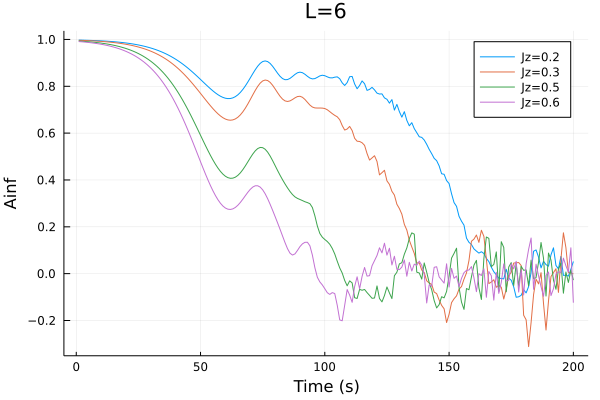

In [13]:
t_list = 10.0 .^(range(-1,stop=3,length=200))
jz_list = [0.2, 0.3, 0.5, 0.6]
Ainfs_list = zeros((length(jz_list), length(t_list)))
for (i, jz) in enumerate(jz_list)
    Ainfs = get_Ainf_AN(6, 0.3, 1.0, jz, 0.9, t_list)
    Ainfs_list[i,:] = Ainfs
end

plot(Ainfs_list',
    title = "L=6", label = ["Jz=0.2" "Jz=0.3" "Jz=0.5" "Jz=0.6"], 
    xlabel="Time (s)", ylabel="Ainf")

# savefig("L8_alex.png") # save the most recent fig as fn